In [1]:
## Primero se importan las librerías necesarias

import subprocess              # para instalar paquetes
import sys                     # para manejar el entorno de Python
import pandas as pd            # manipulación de datos
import spacy                   # procesamiento de lenguaje natural
from tqdm.auto import tqdm     # barras de progreso
import re                      

# Instalar spaCy si no está instalado
subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy", "-q"])

# Descargar el modelo de spaCy para español
subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_lg", "-q"])

print("Librerías importadas correctamente.")

ModuleNotFoundError: No module named 'pandas'

In [3]:
# Cargar el dataset

df = pd.read_csv("Datos/dataset_proyecto_chile_septiembre2025.csv")

print(df.head())
print("Dataset cargado correctamente.")

        _id                    _index _score country country.keyword  \
0  51150648  news_fondecyt_1250207_fr      -   chile           chile   
1  51150651  news_fondecyt_1250207_fr      -   chile           chile   
2  51150653  news_fondecyt_1250207_fr      -   chile           chile   
3  51150655  news_fondecyt_1250207_fr      -   chile           chile   
4  51150657  news_fondecyt_1250207_fr      -   chile           chile   

                          date     id_news media_outlet media_outlet.keyword  \
0  Sep 24, 2025 @ 00:00:00.000  51,150,648         emol                 emol   
1  Sep 24, 2025 @ 00:00:00.000  51,150,651         emol                 emol   
2  Sep 23, 2025 @ 00:00:00.000  51,150,653         emol                 emol   
3  Sep 25, 2025 @ 00:00:00.000  51,150,655         emol                 emol   
4  Sep 25, 2025 @ 00:00:00.000  51,150,657         emol                 emol   

                                                text  \
0  En un incendio terminó el "

In [4]:
# Limpieza de Informacion

def limpiar_dataframe_basico(df_entrada):
    """Selecciona columnas relevantes, filtra textos cortos/nulos y normaliza la fecha."""
    # Seleccionar columnas y copiar el DataFrame
    df_limpio = df_entrada[['date', 'media_outlet', 'title', 'text', 'url']].copy() 

    # Eliminar filas sin título o texto
    df_limpio = df_limpio.dropna(subset=['text', 'title'])

    # Quitar textos muy cortos o basura
    df_limpio = df_limpio[df_limpio['text'].str.len() > 200].copy()

    # parsear y ordenar la fecha ("Sep 24, 2025 @ 00:00:00.000")
    def parsear_fecha(cadena_fecha):
        if pd.isna(cadena_fecha):
            return pd.NaT
        try:
            parte_fecha = str(cadena_fecha).split('@')[0].strip()
            return pd.to_datetime(parte_fecha, format='%b %d, %Y', errors='coerce')
        except Exception:
            return pd.NaT

    # Aplicar parseo y eliminar filas sin fecha válida
    df_limpio['date'] = df_limpio['date'].apply(parsear_fecha)
    df_limpio = df_limpio.dropna(subset=['date'])

    # Columna con fecha en formato YYYY-MM-DD
    df_limpio['fecha_yyyy_mm_dd'] = df_limpio['date'].dt.strftime('%Y-%m-%d')

    print(f"Filas después de limpieza: {len(df_limpio)}")
    return df_limpio

df_limpio = limpiar_dataframe_basico(df)
print(df_limpio.head())

Filas después de limpieza: 10287
        date media_outlet                                              title  \
0 2025-09-24         emol  "Banderazo" de hinchas de la U termina en desm...   
1 2025-09-24         emol  Tras nuevo femicidio: Piden poner urgencia a p...   
2 2025-09-23         emol  Detienen a dos alumnos tras ser sorprendidos c...   
3 2025-09-25         emol  Metro normaliza servicio en Línea 1 tras cierr...   
4 2025-09-25         emol  Seguridad en Mundial Sub 20: Roban a funcionar...   

                                                text  \
0  En un incendio terminó el "banderazo" convocad...   
1  Tras registrarse un nuevo caso de femicidio en...   
2  Carabineros detuvo esta mañana a  dos adolesce...   
3  La mañana de este jueves el Metro de Santiago ...   
4  Este sábado comienza el  Mundial Sub 20 en Chi...   

                                                 url fecha_yyyy_mm_dd  
0  https://www.emol.com/noticias/Nacional/2025/09...       2025-09-24  
1  ht

In [5]:
# Se deefine los elementos para la extracción de NER en batch
nlp = spacy.load("es_core_news_lg", exclude=[
    "tagger", 
    "parser", 
    "attribute_ruler",
    "lemmatizer"
])

# Función para procesar textos en batch
def procesar_batch(textos):
    personas_list = []
    lugares_list = []
    organizaciones_list = []
    
    for doc in tqdm(nlp.pipe(textos, batch_size=256, n_process=12),
                    total=len(textos),
                    desc="Procesando NER"):
        
        personas = {ent.text.strip() for ent in doc.ents if ent.label_ == "PER"}
        lugares = {ent.text.strip() for ent in doc.ents if ent.label_ in ["LOC", "GPE"]}
        organizaciones = {ent.text.strip() for ent in doc.ents if ent.label_ == "ORG"}

        personas_list.append(list(personas))
        lugares_list.append(list(lugares))
        organizaciones_list.append(list(organizaciones))

    return personas_list, lugares_list, organizaciones_list


# Extracción de entidades NER en batch
print("Extrayendo entidades NER en batch…", flush=True)

textos = df_limpio["text"].tolist()
personas, lugares, organizaciones = procesar_batch(textos)

# Agregar las nuevas columnas al DataFrame limpio
df_limpio["personas"] = personas
df_limpio["lugares"] = lugares
df_limpio["organizaciones"] = organizaciones

Extrayendo entidades NER en batch…


Procesando NER: 100%|██████████| 10287/10287 [02:16<00:00, 75.19it/s] 


In [ ]:
import re

# Mapeo exhaustivo de palabras clave a Regiones/Etiquetas
# Agregamos ciudades clave para asegurar detección
MAPA_TERRITORIAL = {
    "Arica y Parinacota": ["arica", "parinacota", "putre"],
    "Tarapacá": ["tarapacá", "iquique", "alto hospicio", "pozo almonte"],
    "Antofagasta": ["antofagasta", "calama", "tocopilla", "san pedro de atacama", "mejillones"],
    "Atacama": ["atacama", "copiapó", "vallenar", "caldera", "chañaral"],
    "Coquimbo": ["coquimbo", "la serena", "ovalle", "illapel", "vicuña", "los vilos"],
    "Valparaíso": ["valparaíso", "viña del mar", "viña", "san antonio", "quillota", "los andes", "san felipe", "quilpué", "villa alemana"],
    "Metropolitana": ["metropolitana", "santiago", "puente alto", "maipú", "la florida", "las condes", "providencia", "ñuñoa", "estación central", "la moneda"],
    "O'Higgins": ["o'higgins", "rancagua", "san fernando", "pichilemu", "rengo", "machalí"],
    "Maule": ["maule", "talca", "curicó", "linares", "cauquenes", "constitución"],
    "Ñuble": ["ñuble", "chillán", "san carlos", "bulnes"],
    "Biobío": ["biobío", "concepción", "talcahuano", "los ángeles", "coronel", "hualpén", "san pedro de la paz"],
    "Araucanía": ["araucanía", "temuco", "padre las casas", "villarrica", "angol", "pucón"],
    "Los Ríos": ["los ríos", "valdivia", "corral", "lanco", "panguipulli", "la unión", "futrono", "río bueno", "mariquina"],
    "Los Lagos": ["los lagos", "puerto montt", "osorno", "castro", "ancud", "puerto varas", "frutillar", "chiloé"],
    "Aysén": ["aysén", "coyhaique", "puerto aysén"],
    "Magallanes": ["magallanes", "punta arenas", "puerto natales", "torres del paine", "antártica"]
}

def detectar_etiquetas_geograficas(row):
    """
    Escanea título, texto y entidades para encontrar coincidencias geográficas.
    Retorna una lista con la Región y las Ciudades encontradas.
    """
    
    # 1. Construir un texto unificado para búsqueda (en minúsculas)
    # Unimos título, texto y la||||s entidades que ya extrajo SpaCy (lugares)
    
    entidades_lugares = " ".join(row['lugares']) if isinstance(row['lugares'], list) else ""
    contenido_total = f"{str(row['title'])} {str(row['text'])} {entidades_lugares}".lower()
    
    etiquetas_encontradas = set()
    
    # 2. Barrido por diccionario
    for region, keywords in MAPA_TERRITORIAL.items():
        for kw in keywords:
            if re.search(r'\b' + re.escape(kw) + r'\b', contenido_total):
                etiquetas_encontradas.add(region) # Agrega la región macro
                etiquetas_encontradas.add(kw.capitalize()) # Agrega la ciudad específica (ej: Valdivia)
                
    return list(etiquetas_encontradas)

# Aplicar la nueva lógica
print("Detección de regiones...")
tqdm.pandas(desc="Detectando Regiones")
df_limpio['regiones'] = df_limpio.progress_apply(detectar_etiquetas_geograficas, axis=1)

Detección de regiones...


Detectando Regiones: 100%|██████████| 10287/10287 [00:33<00:00, 309.14it/s]


In [8]:
# Guardar el JSON mejorado
output_path = "Datos/noticias_enriquecidas_2025.json"
df_final = df_limpio[['title', 'text', 'media_outlet', 'fecha_yyyy_mm_dd', 'url', 'personas', 'lugares', 'organizaciones', 'regiones']].copy()
df_final = df_final.rename(columns={'fecha_yyyy_mm_dd': 'fecha'})
df_final.to_json(output_path, orient="records", force_ascii=False, indent=2)

print(f"\n Dataset guardado en: {output_path}")


 Dataset guardado en: Datos/noticias_enriquecidas_2025.json


--- Iniciando Simulación para Capital: $500 ---
--- Iniciando Simulación para Capital: $1000 ---


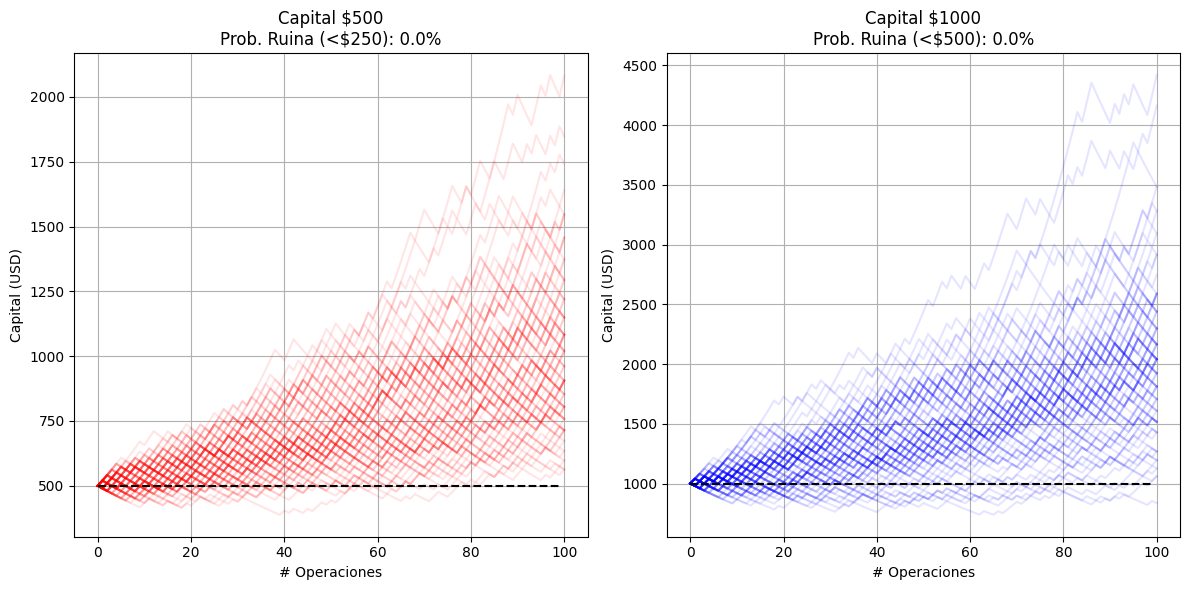


RESULTADOS ESTADÍSTICOS:
Capital $500 -> Promedio Final: $1018.08 | Probabilidad de caer al 50%: 0.0%
Capital $1000 -> Promedio Final: $2051.77 | Probabilidad de caer al 50%: 0.0%


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def correr_montecarlo(capital_inicial, riesgo_pct, win_rate, ratio_riesgo_beneficio, n_trades, n_simulaciones):
    """
    Ejecuta simulaciones de Montecarlo para trading.
    
    Parámetros:
    - capital_inicial: Monto de dinero inicial (USD).
    - riesgo_pct: Porcentaje de la cuenta arriesgado por operación (ej: 0.01 para 1%).
    - win_rate: Probabilidad de ganar (ej: 0.50 para 50%).
    - ratio_riesgo_beneficio: Cuánto ganas por cada unidad arriesgada (ej: 2.0).
    - n_trades: Cantidad de operaciones por simulación.
    - n_simulaciones: Cuántas curvas de equidad generar.
    """
    
    print(f"--- Iniciando Simulación para Capital: ${capital_inicial} ---")
    
    # Matriz para guardar todas las curvas de equidad
    todas_las_curvas = []
    conteo_ruina = 0
    # Definimos 'Ruina' técnica como perder el 50% del capital (Drawdown difícil de recuperar)
    umbral_ruina = capital_inicial * 0.5 

    for i in range(n_simulaciones):
        equity = [capital_inicial]
        capital_actual = capital_inicial
        
        # Generar resultados aleatorios (1 = Win, 0 = Loss)
        # np.random.rand genera números entre 0 y 1. Si es < win_rate, es una victoria.
        resultados = np.random.rand(n_trades) < win_rate
        
        arruinado = False
        
        for es_ganador in resultados:
            # Cálculo del riesgo dinámico (Interés Compuesto)
            monto_riesgo = capital_actual * riesgo_pct
            
            if es_ganador:
                ganancia = monto_riesgo * ratio_riesgo_beneficio
                capital_actual += ganancia
            else:
                capital_actual -= monto_riesgo
            
            equity.append(capital_actual)
            
            if capital_actual <= umbral_ruina:
                arruinado = True
                # Opcional: break aquí si quieres detener la simulación al quebrar
        
        if arruinado:
            conteo_ruina += 1
            
        todas_las_curvas.append(equity)

    prob_ruina = (conteo_ruina / n_simulaciones) * 100
    promedio_final = np.mean([curva[-1] for curva in todas_las_curvas])
    
    return todas_las_curvas, prob_ruina, promedio_final

# --- CONFIGURACIÓN DE PARÁMETROS ---
N_SIMULACIONES = 100
N_TRADES = 100       # Un trader activo podría hacer esto en 1-2 meses
WIN_RATE = 0.45      # 45% de acierto (Estrategia realista de seguimiento de tendencia)
RISK_REWARD = 2.0    # Ganas el doble de lo que arriesgas (1:2)
RIESGO_OPERACION = 0.02 # Arriesgar el 2% por operación

# --- EJECUCIÓN ---
# Escenario 1: Cuenta Pequeña ($500)
curvas_500, ruina_500, final_500 = correr_montecarlo(500, RIESGO_OPERACION, WIN_RATE, RISK_REWARD, N_TRADES, N_SIMULACIONES)

# Escenario 2: Cuenta Recomendada ($1000)
curvas_1000, ruina_1000, final_1000 = correr_montecarlo(1000, RIESGO_OPERACION, WIN_RATE, RISK_REWARD, N_TRADES, N_SIMULACIONES)

# --- VISUALIZACIÓN ---
plt.figure(figsize=(12, 6))

# Subplot 1: Capital $500
plt.subplot(1, 2, 1)
for curva in curvas_500:
    plt.plot(curva, color='red', alpha=0.1) # Alpha bajo para ver la densidad
plt.plot([500]*N_TRADES, 'k--', label='Break Even')
plt.title(f'Capital $500\nProb. Ruina (<$250): {ruina_500}%')
plt.xlabel('# Operaciones')
plt.ylabel('Capital (USD)')
plt.grid(True)

# Subplot 2: Capital $1000
plt.subplot(1, 2, 2)
for curva in curvas_1000:
    plt.plot(curva, color='blue', alpha=0.1)
plt.plot([1000]*N_TRADES, 'k--', label='Break Even')
plt.title(f'Capital $1000\nProb. Ruina (<$500): {ruina_1000}%')
plt.xlabel('# Operaciones')
plt.ylabel('Capital (USD)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nRESULTADOS ESTADÍSTICOS:")
print(f"Capital $500 -> Promedio Final: ${final_500:.2f} | Probabilidad de caer al 50%: {ruina_500}%")
print(f"Capital $1000 -> Promedio Final: ${final_1000:.2f} | Probabilidad de caer al 50%: {ruina_1000}%")